In [8]:

import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import cv2

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

n_samples, h, w = lfw_people.images.shape

print(f"Total dataset size:")
print(f"Number of samples: {n_samples}")
print(f"Image size: {h}x{w}")
print(f"Number of classes (people): {n_classes}")
print(f"People in dataset: {target_names}")


bush_vs_powell_indices = np.where((y == 1) | (y == 3))
X = lfw_people.images[bush_vs_powell_indices]
y = y[bush_vs_powell_indices]


y = (y == 3).astype(int)
binary_target_names = ['Colin Powell', 'George W. Bush']

print("\nShape of our binary classification data (X):", X.shape)
print("Shape of our binary classification labels (y):", y.shape)

s
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=binary_target_names[y[i]])
plt.show()

Total dataset size:
Number of samples: 1288
Image size: 50x37
Number of classes (people): 7
People in dataset: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']

Shape of our binary classification data (X): (766, 50, 37)
Shape of our binary classification labels (y): (766,)


In [3]:
# Normalize pixel values to be between 0 and 1
X_normalized = X / 255.0

# Reshape data to add the channel dimension (height, width, channels)
X_reshaped = np.expand_dims(X_normalized, axis=-1)
print("Original data shape:", X.shape)
print("Reshaped data shape for CNN:", X_reshaped.shape)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Original data shape: (766, 50, 37)
Reshaped data shape for CNN: (766, 50, 37, 1)

Training samples: 612
Testing samples: 154


In [4]:
# Get image dimensions for the input layer
img_height, img_width, channels = X_reshaped.shape[1:]

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, channels)),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the results to feed into a dense layer
    Flatten(),

    # Dense layer for classification
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization to prevent overfitting

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Print a summary of the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 35, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,001 (875.00 KB)

 Trainable params: 224,001 (875.00 KB)

 Non-trainable params: 0 (0.00 B)

Class weights to balance the dataset: {0: np.float64(1.619047619047619), 1: np.float64(0.723404255319149)}
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.6804 - loss: 0.7607 - val_accuracy: 0.6948 - val_loss: 0.6509
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6969 - loss: 0.6941 - val_accuracy: 0.6948 - val_loss: 0.6674
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7028 - loss: 0.6864 - val_accuracy: 0.6948 - val_loss: 0.6708
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7021 - loss: 0.6860 - val_accuracy: 0.6948 - val_loss: 0.6743
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6832 - loss: 0.7001 - val_accuracy: 0.6948 - val_loss: 0.6772
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6923 - loss: 0.6929 - val_accuracy: 0.6948 - val_loss: 0.6791
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7052 - loss: 0.6841 - val_accuracy: 0.6948 - val_loss: 0.6810
Epoch 8/2

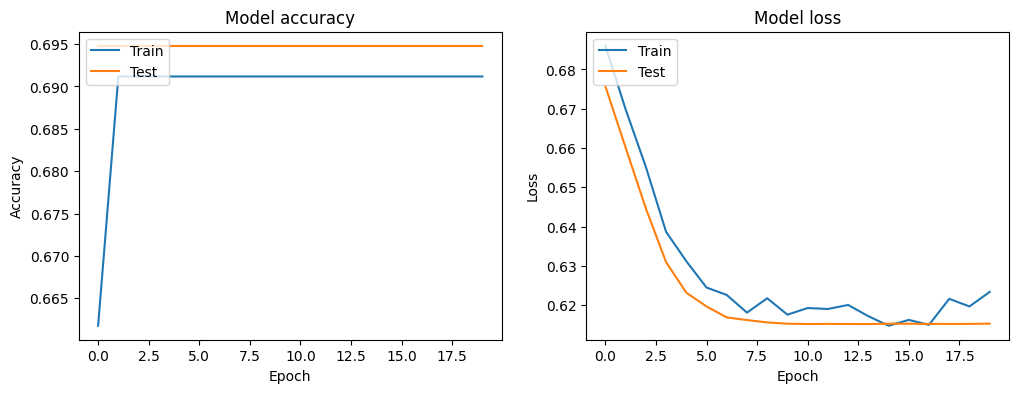

In [11]:

from sklearn.utils import class_weight

# Calculate the class weights to handle the imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights to balance the dataset:", class_weights_dict)


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


epochs = 20
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    batch_size=32,
    class_weight=class_weights_dict
)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    batch_size=32
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Test Accuracy: 69.48%
Test Loss: 0.6169
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report:
                precision    recall  f1-score   support

  Colin Powell       0.00      0.00      0.00        47
George W. Bush       0.69      1.00      0.82       107

      accuracy                           0.69       154
     macro avg       0.35      0.50      0.41       154
  weighted avg       0.48      0.69      0.57       154


Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


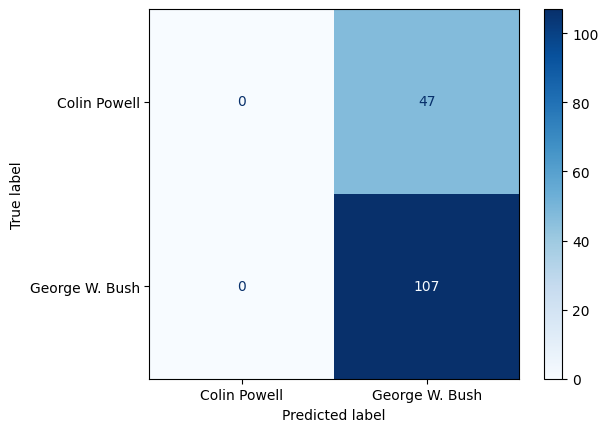

In [9]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')
print(f'Test Loss: {loss:.4f}')

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32") # Convert probabilities to binary predictions (0 or 1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=binary_target_names))

# Display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()